In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import pandas as pd
from statistics import mean
import statsmodels.api as sm
from statsmodels.formula.api import ols
import json

In [2]:
with open('test_result.json') as json_file:
    test_result = json.load(json_file)

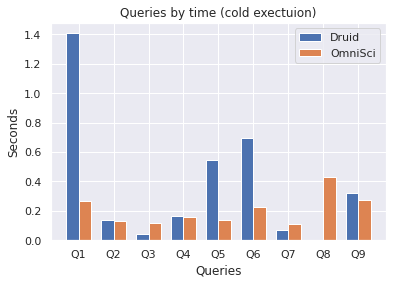

In [3]:
labels = test_result["queries"].keys()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

druid_means = [test_result["timings"]["druid"][label][0] for label in labels]
omnisci_means = [test_result["timings"]["omnisci"][label][0] for label in labels]


fig, ax = plt.subplots()
ax.bar(x - width/2, druid_means, width, label='Druid')
ax.bar(x + width/2, omnisci_means, width, label='OmniSci')

ax.set_title('Queries by time (cold exectuion)')
ax.set_xlabel('Queries')
ax.set_ylabel('Seconds')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

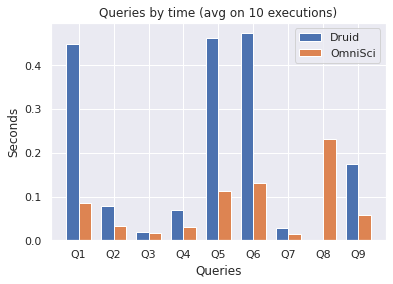

In [4]:
labels = test_result["queries"].keys()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

druid_means = [mean(test_result["timings"]["druid"][label]) for label in labels]
omnisci_means = [mean(test_result["timings"]["omnisci"][label]) for label in labels]


fig, ax = plt.subplots()
ax.bar(x - width/2, druid_means, width, label='Druid')
ax.bar(x + width/2, omnisci_means, width, label='OmniSci')

ax.set_title('Queries by time (avg on 10 executions)')
ax.set_xlabel('Queries')
ax.set_ylabel('Seconds')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [5]:
data = pd.DataFrame(columns=['Query_ID', 'ExecutionTime', 'Context'])

In [6]:
for context in test_result["timings"].keys():
    for query, timings in test_result["timings"][context].items():
        for timing in timings:
            data = data.append({'Query_ID': query, 'ExecutionTime': timing, 'Context': context}, ignore_index=True)
data

,Query_ID,ExecutionTime,Context
0,Q1,1.408279,druid
1,Q1,0.673336,druid
2,Q1,0.516575,druid
3,Q1,0.519643,druid
4,Q1,0.458263,druid
...,...,...,...
506,Q9,0.046968,omnisci
507,Q9,0.049684,omnisci
508,Q9,0.051832,omnisci
509,Q9,0.050811,omnisci


In [7]:
results_lm = ols('ExecutionTime ~ C(Context, Sum)*C(Query_ID, Sum)', data=data).fit()

In [8]:
table = sm.stats.anova_lm(results_lm, typ=2)

In [9]:
table

,sum_sq,df,F,PR(>F)
"C(Context, Sum)",2.929740,1.0,890.549186,1.520815e-112
"C(Query_ID, Sum)",7.189121,8.0,273.158445,9.219881e-176
"C(Context, Sum):C(Query_ID, Sum)",2.931056,8.0,111.368667,2.175574e-105
Residual,1.621878,493.0,NaN,NaN
